In [4]:
import gymnasium as gym
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import ale_py

gym.register_envs(ale_py)

env = gym.make("ALE/Pong-v5")
obs, info = env.reset()

#np.unique(obs[34:-16].reshape(-1, obs.shape[2]), axis=0)

array([[ 53,  95,  24],
       [101, 111, 228],
       [109, 118,  43]], dtype=uint8)

In [2]:
# detect colors
gym.register_envs(ale_py)

env = gym.make("ALE/Pong-v5")
env.reset()

colors = set()

for _ in range(100):
    action = env.action_space.sample()

    obs, reward, terminated, truncated, info = env.step(action)

    for color in np.unique(obs[34:-16].reshape(-1, obs.shape[2]), axis=0):
        colors.add(tuple(color))

    if terminated or truncated:
        obs, info = env.reset()

env.close()

print(colors)

# colors human: 213, 130, 74; 144, 72, 17; 92, 186, 92; 236, 236, 236

{(np.uint8(213), np.uint8(130), np.uint8(74)), (np.uint8(144), np.uint8(72), np.uint8(17)), (np.uint8(92), np.uint8(186), np.uint8(92)), (np.uint8(236), np.uint8(236), np.uint8(236))}


In [14]:
class Agent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float,
    ):
        """Initialize a Q-Learning agent.

        Args:
            env: The training environment
            learning_rate: How quickly to update Q-values (0-1)
            initial_epsilon: Starting exploration rate (usually 1.0)
            epsilon_decay: How much to reduce epsilon each episode
            final_epsilon: Minimum exploration rate (usually 0.1)
            discount_factor: How much to value future rewards (0-1)
        """
        self.env = env

        # Q-table: maps (state, action) to expected reward
        # defaultdict automatically creates entries with zeros for new states
        self.qA_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.qB_values = defaultdict(lambda: np.zeros(env.action_space.n))
        
        self.lr = learning_rate
        self.discount_factor = discount_factor  # How much we care about future rewards

        # Exploration parameters
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        # Track learning progress
        self.training_error = []

    def get_action(self, env, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            combined_q = self.qA_values[obs] + self.qB_values[obs]
            return int(np.argmax(combined_q)) 


    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        if np.random.random() < 0.5:
            # qB selects action
            future_q_value = (not terminated) * np.max(self.qA_values[next_obs])
            temporal_difference = (
                reward + self.discount_factor * future_q_value - self.qB_values[obs][action]
            )

            # upate qB
            self.qB_values[obs][action] = (
                self.qB_values[obs][action] + self.lr * temporal_difference
            )
            self.training_error.append(temporal_difference)
        else: 
            # use qA to check
            future_q_value = (not terminated) * np.max(self.qB_values[next_obs])
            temporal_difference = (
                reward + self.discount_factor * future_q_value - self.qA_values[obs][action]
            )

            # update qA
            self.qA_values[obs][action] = (
                self.qA_values[obs][action] + self.lr * temporal_difference
            )
            self.training_error.append(temporal_difference)
            
    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [15]:
# hyperparameters
learning_rate = 0.1
n_episodes = 10_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1
discount_factor = 1

agent = Agent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount_factor,
)


In [16]:
# reset the environment to get the first observation
done = False
observation, info = env.reset()

# sample a random action from all valid actions
action = env.action_space.sample()

# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action)

In [17]:
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(env, obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

  0%|                                                 | 0/10000 [00:00<?, ?it/s]


TypeError: unhashable type: 'numpy.ndarray'

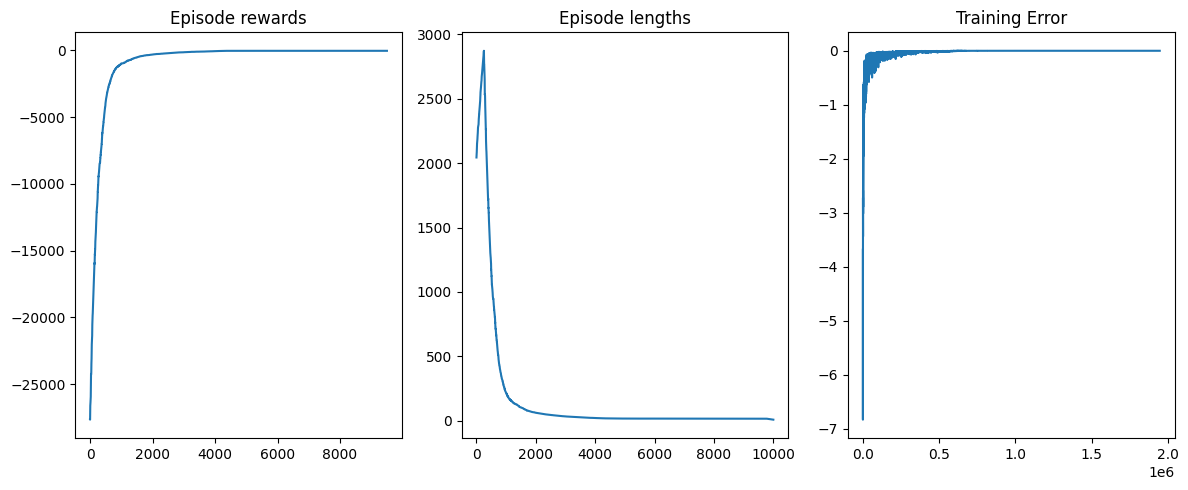

In [71]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()


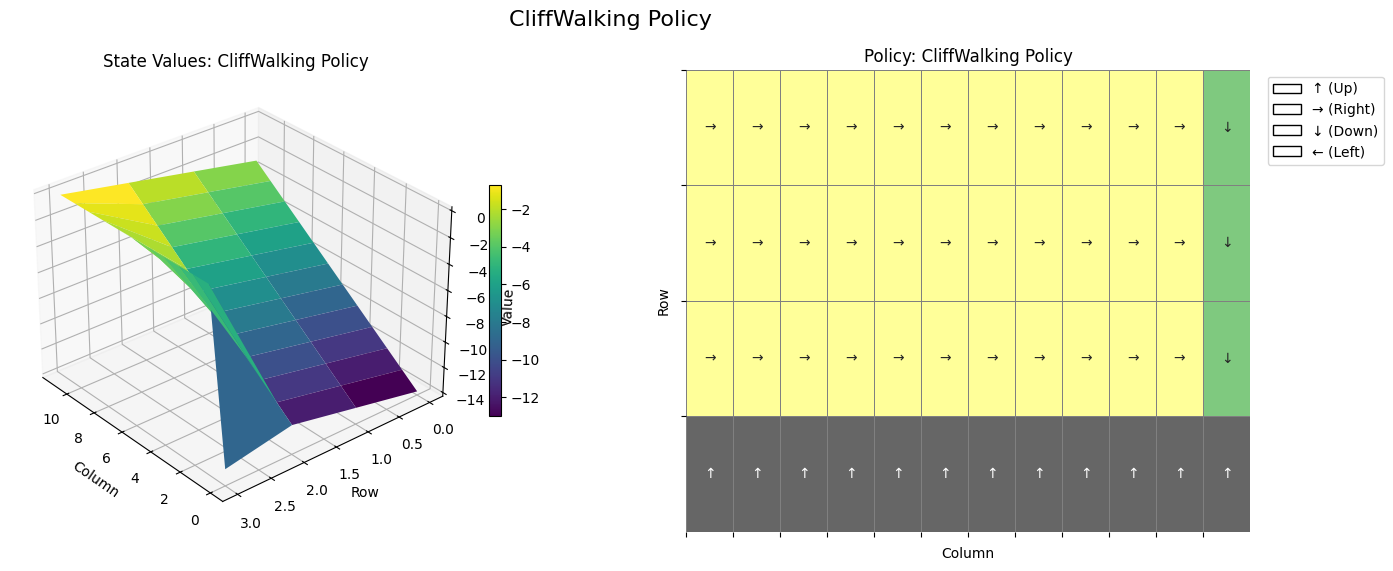

In [72]:
def create_grids(agent):
    """Create value and policy grids for CliffWalking."""
    rows, cols = 4, 12
    value_arr = np.zeros((rows, cols))
    policy_arr = np.zeros((rows, cols), dtype=int)
    
    for state in range(rows * cols):
        row = state // cols  # Convert state index to row
        col = state % cols   # Convert state index to column
        if state in agent.qA_values:
            value_arr[row, col] = np.max(agent.qA_values[state])
            policy_arr[row, col] = np.argmax(agent.qA_values[state])
    return value_arr, policy_arr

def create_plots(value_arr, policy_arr, title: str):
    """Create plots for CliffWalking policy visualization."""
    fig = plt.figure(figsize=(16, 6))
    fig.suptitle(title, fontsize=16)
    
    # 1. State Values (3D Surface Plot)
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    x = np.arange(12)  # Columns
    y = np.arange(4)   # Rows
    X, Y = np.meshgrid(x, y)
    surf = ax1.plot_surface(
        X, Y, value_arr, rstride=1, cstride=1, 
        cmap='viridis', edgecolor='none'
    )
    ax1.set_title(f"State Values: {title}")
    ax1.set_xlabel('Column')
    ax1.set_ylabel('Row')
    ax1.set_zlabel('Value')
    ax1.view_init(30, 140)  # Adjust viewing angle
    fig.colorbar(surf, ax=ax1, shrink=0.5)
    
    # 2. Policy (Annotated Heatmap)
    ax2 = fig.add_subplot(1, 2, 2)
    # Map actions to arrows
    annot = np.empty_like(policy_arr).astype(str)
    arrow_map = {0: "↑", 1: "→", 2: "↓", 3: "←"}
    for i in range(4):
        for j in range(12):
            annot[i, j] = arrow_map.get(policy_arr[i, j], "?")
    
    # Create heatmap with annotations
    sns.heatmap(
        policy_arr, ax=ax2, annot=annot, fmt="", 
        cmap="Accent_r", cbar=False, linewidths=0.5, linecolor="gray"
    )
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Column")
    ax2.set_ylabel("Row")
    ax2.set_xticks(np.arange(12))
    ax2.set_yticks(np.arange(4))
    
    # Add legend for actions
    legend_elements = [
        Patch(facecolor='white', edgecolor='black', label='↑ (Up)'),
        Patch(facecolor='white', edgecolor='black', label='→ (Right)'),
        Patch(facecolor='white', edgecolor='black', label='↓ (Down)'),
        Patch(facecolor='white', edgecolor='black', label='← (Left)')
    ]
    ax2.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.25, 1))
    
    return fig

value_grid, policy_grid = create_grids(agent)
fig = create_plots(value_grid, policy_grid, title="CliffWalking Policy")
plt.show()